# Student Name: Saeedreza Zouashkiani
# Student ID: 400206262

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import os
from utils import print_metrics, count_parameters, train_model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter('runs/q1/fc')

In [2]:
# initialize the dataset and split into train val and test sets with a ratio of 60:10:30
# transform normalize and resize the images to 150*150
transform = transforms.Compose([transforms.Resize((150, 150)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = torchvision.datasets.ImageFolder(root='Shoe vs Sandal vs Boot Dataset', transform=transform)
train_size = int(0.6 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

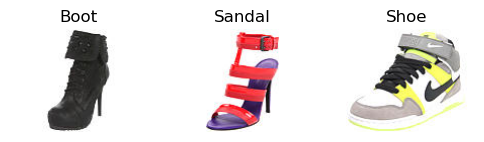

In [3]:
def plot_images(num_images=1, root_dir="Shoe vs Sandal vs Boot Dataset"):
    classes = os.listdir(root_dir)
    plt.figure(figsize=(len(classes) * 2, num_images * 2))
    for i in range(len(classes)):
        for j in range(num_images):
            # get a random image from the class
            img_name = np.random.choice(os.listdir(os.path.join(root_dir, classes[i])))
            img_path = os.path.join(root_dir, classes[i], img_name)
            img = plt.imread(img_path)
            plt.subplot(num_images, len(classes), i * num_images + j + 1)
            plt.imshow(img)
            plt.title(classes[i])
            plt.axis("off")
    plt.show()
plot_images()

In [4]:
class MLP(nn.Module):
    def __init__(self, hidden_layers):
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_layers) - 1):
            self.hidden_layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
        self.dropout = nn.Dropout(0.2)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        for i, linear in enumerate(self.hidden_layers):
            if i != len(self.hidden_layers) - 1:
                x = F.relu(linear(x))
                x = self.dropout(x)
            else:
                x = self.softmax(linear(x))
        return x

In [5]:
hidden_layers = [150 * 150 * 3, 128, 64, 3]
criterion = nn.CrossEntropyLoss()
fc_model = MLP(hidden_layers).to(device)
# add the model to the tensorboard
writer.add_graph(fc_model, torch.rand(1, 3, 150, 150).to(device))
writer.close()

optimizer = optim.Adam(fc_model.parameters(), lr=1e-4)
train_loss, val_loss, train_acc, val_acc = train_model(fc_model, train_loader, val_loader,
                                                       epochs=10, criterion=criterion, optimizer=optimizer,
                                                       writer=writer, device=device, verbose=True)
# save the model
torch.save(fc_model.state_dict(), "fc_model.pt")

Epoch: 1/10 	 Train loss: 0.756 	 Train accuracy: 0.795 	 val loss: 0.703 	 val accuracy: 0.853
Epoch: 2/10 	 Train loss: 0.697 	 Train accuracy: 0.854 	 val loss: 0.678 	 val accuracy: 0.871
Epoch: 3/10 	 Train loss: 0.677 	 Train accuracy: 0.875 	 val loss: 0.681 	 val accuracy: 0.867
Epoch: 4/10 	 Train loss: 0.664 	 Train accuracy: 0.889 	 val loss: 0.661 	 val accuracy: 0.884
Epoch: 5/10 	 Train loss: 0.660 	 Train accuracy: 0.891 	 val loss: 0.655 	 val accuracy: 0.899
Epoch: 6/10 	 Train loss: 0.648 	 Train accuracy: 0.905 	 val loss: 0.648 	 val accuracy: 0.905
Epoch: 7/10 	 Train loss: 0.643 	 Train accuracy: 0.910 	 val loss: 0.660 	 val accuracy: 0.887
Epoch: 8/10 	 Train loss: 0.636 	 Train accuracy: 0.915 	 val loss: 0.646 	 val accuracy: 0.905
Epoch: 9/10 	 Train loss: 0.632 	 Train accuracy: 0.920 	 val loss: 0.639 	 val accuracy: 0.911
Epoch: 10/10 	 Train loss: 0.631 	 Train accuracy: 0.922 	 val loss: 0.641 	 val accuracy: 0.907


The model has 8,648,579 trainable parameters
              precision    recall  f1-score   support

        Boot       0.95      0.92      0.93      1495
      Sandal       0.87      0.91      0.89      1534
        Shoe       0.92      0.90      0.91      1471

    accuracy                           0.91      4500
   macro avg       0.91      0.91      0.91      4500
weighted avg       0.91      0.91      0.91      4500



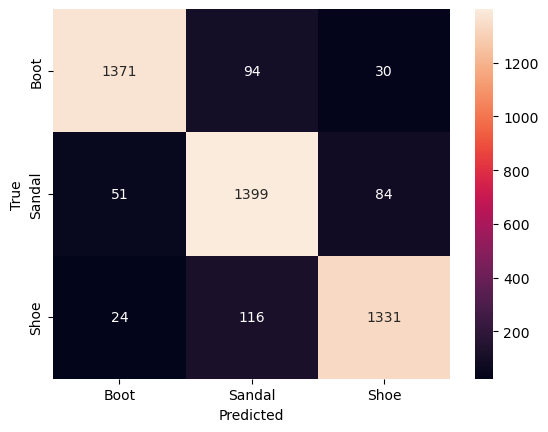

In [6]:
# Metrics for the test set
classes = os.listdir("Shoe vs Sandal vs Boot Dataset")
print(f'The model has {count_parameters(fc_model):,} trainable parameters')    
print_metrics(fc_model, test_loader, classes=classes, device=device)

In [7]:
class DropBlock2d(nn.Module):
    """Randomly zeroes 2D spatial blocks of the input tensor.
    As described in the paper
    `DropBlock: A regularization method for convolutional networks`_ ,
    dropping whole blocks of feature map allows to remove semantic
    information as compared to regular dropout.
    Args:
        drop_prob (float): probability of an element to be dropped.
        block_size (int): size of the block to drop
    Shape:
        - Input: `(N, C, H, W)`
        - Output: `(N, C, H, W)`
    .. _DropBlock: A regularization method for convolutional networks:
       https://arxiv.org/abs/1810.12890
       https://github.com/miguelvr/dropblock
    """

    def __init__(self, drop_prob, block_size):
        super(DropBlock2d, self).__init__()

        self.drop_prob = drop_prob
        self.block_size = block_size

    def forward(self, x):
        # shape: (bsize, channels, height, width)

        assert x.dim() == 4, \
            "Expected input with 4 dimensions (bsize, channels, height, width)"

        if not self.training or self.drop_prob == 0.:
            return x
        else:
            # get gamma value
            gamma = self._compute_gamma(x)

            # sample mask
            mask = (torch.rand(x.shape[0], *x.shape[2:]) < gamma).float()

            # place mask on input device
            mask = mask.to(x.device)

            # compute block mask
            block_mask = self._compute_block_mask(mask)

            # apply block mask
            out = x * block_mask[:, None, :, :]

            # scale output
            out = out * block_mask.numel() / block_mask.sum()

            return out

    def _compute_block_mask(self, mask):
        block_mask = F.max_pool2d(input=mask[:, None, :, :],
                                  kernel_size=(self.block_size, self.block_size),
                                  stride=(1, 1),
                                  padding=self.block_size // 2)

        if self.block_size % 2 == 0:
            block_mask = block_mask[:, :, :-1, :-1]

        block_mask = 1 - block_mask.squeeze(1)

        return block_mask

    def _compute_gamma(self, x):
        return self.drop_prob / (self.block_size ** 2)

In [8]:
class CNN(nn.Module):
    def __init__(self, block_dropout=True):
        super(CNN, self).__init__()
        self.block_dropout = block_dropout
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 18 * 18, 400)
        self.fc2 = nn.Linear(400, 3)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.batchnorm4 = nn.BatchNorm1d(400)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.softmax = nn.Softmax(dim=1)
        if self.block_dropout:
            self.dropblock1 = DropBlock2d(0.1, 3)
            self.dropblock2 = DropBlock2d(0.1, 3)
            self.dropblock3 = DropBlock2d(0.1, 3)
            
    def forward(self, x):
        x = self.maxpool(F.relu(self.batchnorm1(self.conv1(x))))
        if self.block_dropout:
            x = self.dropblock1(x)
        else:
            x = F.dropout(x, 0.2, training=self.training)
        x = self.maxpool(F.relu(self.batchnorm2(self.conv2(x))))
        if self.block_dropout:
            x = self.dropblock2(x)
        else:
            x = F.dropout(x, 0.2, training=self.training)
        x = self.maxpool(F.relu(self.batchnorm3(self.conv3(x))))
        if self.block_dropout:
            x =  self.dropblock3(x)
        else:
            x = F.dropout(x, 0.2, training=self.training)
        x = x.view(-1, 64 * 18 * 18)
        x = F.relu(self.batchnorm4(self.fc1(x)))
        x = F.dropout(x, 0.2, training=self.training)
        x = self.softmax(self.fc2(x))
        return x

In [9]:
# initialize the model and move it to GPU and add to tensorboard
writer = SummaryWriter("runs/q1/cnn_dropout")
cnn_model = CNN(block_dropout=False).to(device)
writer.add_graph(cnn_model, torch.rand(1, 3, 150, 150).to(device))
writer.close()

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-4)

# train the model
train_loss_cnn, val_loss_cnn, train_acc_cnn, val_acc_cnn = train_model(cnn_model, train_loader, val_loader,
                                                                       epochs=10, criterion=criterion, optimizer=optimizer,
                                                                       writer=writer, device=device, verbose=True)
# save the model
torch.save(cnn_model.state_dict(), "cnn_model_droput.pt")

Epoch: 1/10 	 Train loss: 0.674 	 Train accuracy: 0.895 	 val loss: 0.744 	 val accuracy: 0.819
Epoch: 2/10 	 Train loss: 0.617 	 Train accuracy: 0.949 	 val loss: 0.704 	 val accuracy: 0.856
Epoch: 3/10 	 Train loss: 0.600 	 Train accuracy: 0.961 	 val loss: 0.673 	 val accuracy: 0.887
Epoch: 4/10 	 Train loss: 0.591 	 Train accuracy: 0.969 	 val loss: 0.620 	 val accuracy: 0.936
Epoch: 5/10 	 Train loss: 0.584 	 Train accuracy: 0.976 	 val loss: 0.623 	 val accuracy: 0.935
Epoch: 6/10 	 Train loss: 0.580 	 Train accuracy: 0.979 	 val loss: 0.636 	 val accuracy: 0.924
Epoch: 7/10 	 Train loss: 0.576 	 Train accuracy: 0.981 	 val loss: 0.640 	 val accuracy: 0.916
Epoch: 8/10 	 Train loss: 0.573 	 Train accuracy: 0.984 	 val loss: 0.633 	 val accuracy: 0.922
Epoch: 9/10 	 Train loss: 0.572 	 Train accuracy: 0.984 	 val loss: 0.607 	 val accuracy: 0.946
Epoch: 10/10 	 Train loss: 0.568 	 Train accuracy: 0.988 	 val loss: 0.623 	 val accuracy: 0.930


The model has 8,320,611 trainable parameters
              precision    recall  f1-score   support

        Boot       0.85      0.99      0.92      1495
      Sandal       0.98      0.89      0.93      1534
        Shoe       0.96      0.90      0.93      1471

    accuracy                           0.93      4500
   macro avg       0.93      0.93      0.93      4500
weighted avg       0.93      0.93      0.93      4500



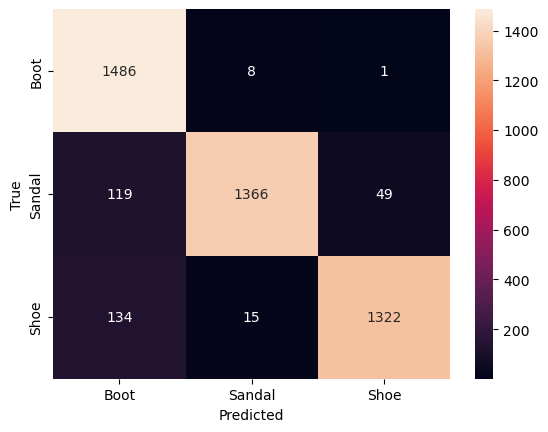

In [10]:
# Metrics for the test set

print(f'The model has {count_parameters(cnn_model):,} trainable parameters')
print_metrics(cnn_model, test_loader, classes=classes, device=device)

The training accuracy for the cnn model with simple dropout is much higher than the validation accuracy which means that the model is possibly overfitting. But because the test distribution is the same as the training and validation sets, the test accuracy is also high. The problem with simple dropout after convolutional layers is that it randomly drops out some of the neurons in the convolutional layers which means that the model is not able to learn the features of the images. Since convolutional layers have few parameters, they need less regularization to begin with. Furthermore, because of the spatial relationships encoded in feature maps, activations can become highly correlated. This renders dropout ineffective. For this reason, we use BlockDropout which is a more effective way of regularizing convolutional layers.

In [11]:
# initialize the model and move it to GPU and add to tensorboard
writer = SummaryWriter("runs/q1/cnn_block_dropout")
cnn_model_dropout = CNN(block_dropout=True).to(device)
writer.add_graph(cnn_model_dropout, torch.rand(1, 3, 150, 150).to(device))
writer.close()

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model_dropout.parameters(), lr=1e-4)

# train the model
train_loss_cnn_dropout, val_loss_cnn_dropout, train_acc_cnn_dropout, val_acc_cnn_dropout = train_model(cnn_model_dropout, train_loader, val_loader,
                                                                                                       epochs=10, criterion=criterion, optimizer=optimizer, writer=writer,
                                                                                                       device=device, verbose=True)
# save the model
torch.save(cnn_model_dropout.state_dict(), "cnn_model_block_dropout.pt")

Epoch: 1/10 	 Train loss: 0.684 	 Train accuracy: 0.884 	 val loss: 0.628 	 val accuracy: 0.940
Epoch: 2/10 	 Train loss: 0.619 	 Train accuracy: 0.948 	 val loss: 0.629 	 val accuracy: 0.932
Epoch: 3/10 	 Train loss: 0.599 	 Train accuracy: 0.963 	 val loss: 0.593 	 val accuracy: 0.967
Epoch: 4/10 	 Train loss: 0.589 	 Train accuracy: 0.972 	 val loss: 0.589 	 val accuracy: 0.967
Epoch: 5/10 	 Train loss: 0.581 	 Train accuracy: 0.979 	 val loss: 0.589 	 val accuracy: 0.969
Epoch: 6/10 	 Train loss: 0.576 	 Train accuracy: 0.982 	 val loss: 0.581 	 val accuracy: 0.977
Epoch: 7/10 	 Train loss: 0.572 	 Train accuracy: 0.985 	 val loss: 0.578 	 val accuracy: 0.977
Epoch: 8/10 	 Train loss: 0.569 	 Train accuracy: 0.988 	 val loss: 0.577 	 val accuracy: 0.977
Epoch: 9/10 	 Train loss: 0.568 	 Train accuracy: 0.988 	 val loss: 0.588 	 val accuracy: 0.968
Epoch: 10/10 	 Train loss: 0.565 	 Train accuracy: 0.992 	 val loss: 0.579 	 val accuracy: 0.977


The model has 8,320,611 trainable parameters
              precision    recall  f1-score   support

        Boot       0.98      0.98      0.98      1495
      Sandal       0.99      0.95      0.97      1534
        Shoe       0.95      0.98      0.97      1471

    accuracy                           0.97      4500
   macro avg       0.97      0.97      0.97      4500
weighted avg       0.97      0.97      0.97      4500



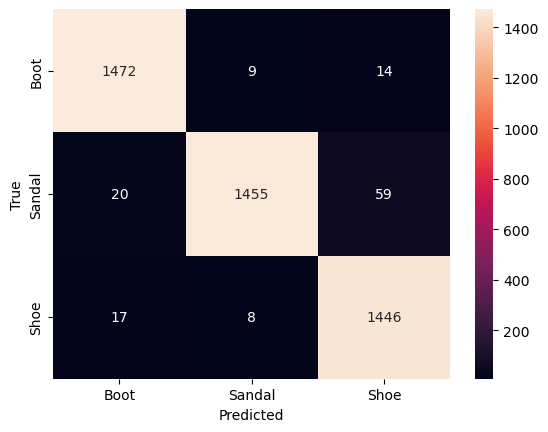

In [12]:
# Metrics for the test set
print(f'The model has {count_parameters(cnn_model_dropout):,} trainable parameters')
print_metrics(cnn_model_dropout, test_loader, classes=classes, device=device)

As we can see, this model can generalize better than the previous model, which shows that DropBlock is a better regularization method for convolutional layers.

In [13]:
class CNN_factorized(nn.Module):
    def __init__(self, block_dropout=True):
        super(CNN_factorized, self).__init__()
        self.block_dropout = block_dropout
        depth_conv1 = nn.Conv2d(3, 3, kernel_size=3, padding=1, groups=3)
        point_conv1 = nn.Conv2d(3, 16, kernel_size=1)
        depth_conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1, groups=16)
        point_conv2 = nn.Conv2d(16, 32, kernel_size=1)
        depth_conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1, groups=32)
        point_conv3 = nn.Conv2d(32, 64, kernel_size=1)
        self.depthwise_seperable_conv1 = nn.Sequential(depth_conv1, point_conv1)
        self.depthwise_seperable_conv2 = nn.Sequential(depth_conv2, point_conv2)
        self.depthwise_seperable_conv3 = nn.Sequential(depth_conv3, point_conv3)
        self.fc1 = nn.Linear(64 * 18 * 18, 400)
        self.fc2 = nn.Linear(400, 3)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.batchnorm4 = nn.BatchNorm1d(400)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.softmax = nn.Softmax(dim=1)
        if self.block_dropout:
            self.dropblock1 = DropBlock2d(0.2, 3) 
            self.dropblock2 = DropBlock2d(0.2, 3)
            self.dropblock3 = DropBlock2d(0.2, 3)
    def forward(self, x):
        x = self.maxpool(F.relu(self.batchnorm1(self.depthwise_seperable_conv1(x))))
        if self.block_dropout:
            x = self.dropblock1(x)
        else:
            x = F.dropout(x, 0.2, training=self.training)
        x = self.maxpool(F.relu(self.batchnorm2(self.depthwise_seperable_conv2(x))))
        if self.block_dropout:
            x = self.dropblock2(x)
        else:
            x = F.dropout(x, 0.2, training=self.training)
        x = self.maxpool(F.relu(self.batchnorm3(self.depthwise_seperable_conv3(x))))
        if self.block_dropout:
            x = self.dropblock3(x)
        else:
            x = F.dropout(x, 0.2, training=self.training)
        x = x.view(-1, 64 * 18 * 18)
        x = F.relu(self.batchnorm4(self.fc1(x)))
        x = F.dropout(x, 0.2, training=self.training)
        x = self.softmax(self.fc2(x))
        return x

In [14]:
# initialize the model and move it to GPU and add to tensorboard
writer = SummaryWriter("runs/q1/cnn_factorized")
cnn_model_factorized = CNN_factorized().to(device)
writer.add_graph(cnn_model_factorized, torch.rand(1, 3, 150, 150).to(device))
writer.close()

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model_factorized.parameters(), lr=1e-4)

# train the model
cnn_factorized_train_losses, cnn_factorized_train_acc, cnn_factorized_val_losses, cnn_factorized_val_acc = train_model(cnn_model_factorized, train_loader, val_loader,
                                                                                                                       epochs=10, criterion=criterion, optimizer=optimizer, writer=writer,
                                                                                                                       device=device, verbose=True)
# save the model
torch.save(cnn_model_factorized.state_dict(), "cnn_model__factorized.pt")

Epoch: 1/10 	 Train loss: 0.725 	 Train accuracy: 0.840 	 val loss: 0.686 	 val accuracy: 0.881
Epoch: 2/10 	 Train loss: 0.665 	 Train accuracy: 0.903 	 val loss: 0.660 	 val accuracy: 0.901
Epoch: 3/10 	 Train loss: 0.640 	 Train accuracy: 0.924 	 val loss: 0.641 	 val accuracy: 0.924
Epoch: 4/10 	 Train loss: 0.630 	 Train accuracy: 0.933 	 val loss: 0.624 	 val accuracy: 0.937
Epoch: 5/10 	 Train loss: 0.619 	 Train accuracy: 0.943 	 val loss: 0.622 	 val accuracy: 0.940
Epoch: 6/10 	 Train loss: 0.609 	 Train accuracy: 0.953 	 val loss: 0.621 	 val accuracy: 0.936
Epoch: 7/10 	 Train loss: 0.605 	 Train accuracy: 0.956 	 val loss: 0.621 	 val accuracy: 0.931
Epoch: 8/10 	 Train loss: 0.599 	 Train accuracy: 0.961 	 val loss: 0.607 	 val accuracy: 0.944
Epoch: 9/10 	 Train loss: 0.596 	 Train accuracy: 0.964 	 val loss: 0.603 	 val accuracy: 0.953
Epoch: 10/10 	 Train loss: 0.593 	 Train accuracy: 0.965 	 val loss: 0.605 	 val accuracy: 0.950


The model has 8,300,257 trainable parameters
              precision    recall  f1-score   support

        Boot       0.94      0.99      0.96      1495
      Sandal       0.97      0.93      0.95      1534
        Shoe       0.96      0.94      0.95      1471

    accuracy                           0.95      4500
   macro avg       0.95      0.95      0.95      4500
weighted avg       0.95      0.95      0.95      4500



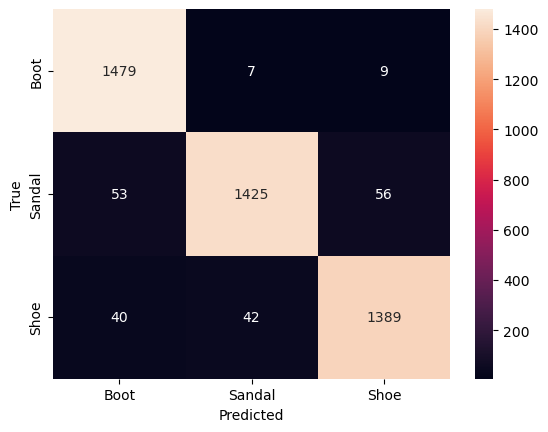

In [15]:
# Metrics for the test set
print(f'The model has {count_parameters(cnn_model_factorized):,} trainable parameters')
print_metrics(cnn_model_factorized, test_loader, classes=classes, device=device)

This model is also able to generalize very well, but since we used factorized kernels, the model is not able to learn the features of the images as well as the previous model (CNN with DropBlock). This is because factorized kernels have fewer parameters than regular kernels, so they are not able to learn the features of the images as well as regular kernels.
Generally speaking, factorized kernels reduce the number of parameters in the model, which makes the training faster and the model to take less memory. In this problem however, because we wanted to compare the performance of MLP with CNN, we used the same number of parameters. Therefore, the reduced number of parameters in the CNN model didn't show up.

# The tensorboard results are shown in the README.md file.